In [ ]:
#### summary for model's accurace(top 1)
#### Dec. 6, 2023.
#### 1) scaled data => R2 : 0.8581771955961001
#### 2) inversed data(original data) => R2 :  0.8697126121057375

### 1) import necessary Librarys

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #how to install : pip install scikit-learn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

In [4]:
# !pip install matplotlib

### #######(Function : split_sequence(data, steps)) LSTM에 입력할 데이터 형식으로 변형

##### LSTM layer에 입력하기 위해 3차원 데이터로 만들어준다 : reshape(datasize, time steps, features)
##### (tip)keras에서 제공하는 RNN(Recurrent Neural Network) layer : SimpleRNN, GRU, LSTM 등
##### LSTM : Long Short-Term Memory, 긴 sequence를 기억한다.

In [5]:
# steps(n_steps_in), input_dimention(columns)에 따라 data(sequence) 가공하여
# x_data, y_data에 담는다
# import numpy as np
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in):
 stepsize_data_x = []
 stepsize_data_y = []
 for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        #gather input(seq_x) and output(seq_y) parts of the pattern
        #1)측정소(A,B,C,D)에서 3개측정소(B,C,D)의 5개(step, n_steps_in)행의 PM값을 x로
        #2)1개측정소(A)의 step+1번째 행의 1열 PM값을 y로 한다.
        #즉)인근 3개측정소의 과거 5시간(steps)동안의 pm값을 x로 하고, target(예측대상) 측정소 1개의 현재(미래) pm값을 y로 함
        seq_x, seq_y = sequence[i:end_ix, 1:], sequence[end_ix,0]
        stepsize_data_x.append(seq_x)
        stepsize_data_y.append(seq_y)
 stepsize_data_x = np.array(stepsize_data_x)
 stepsize_data_y = np.array(stepsize_data_y)

 return stepsize_data_x, stepsize_data_y   
 # return array(stepsize_data_x), array(stepsize_data_y)

In [6]:
# def load_time_series_data(data, sequence_length):
#     print(data.shape)
#     print(sequence_length)
#     window_length = sequence_length + 1
#     x_data = []
#     y_data = []
#     for i in range(0, len(data) - window_length + 1): #0 1 2 3 4 5 6 7 8 9 | 10
#         window = data[i:i + window_length, :]
#         x_data.append(window[:-1, :])
#         y_data.append(window[-1, [-1]])
#     x_data = np.array(x_data)
#     y_data = np.array(y_data)
#     print(x_data.shape)
#     print(y_data.shape)

#     return x_data, y_data

### 2) bring a original data

In [7]:
# df = pd.read_pickle('./total_df.pkl')
df = pd.read_pickle('./data/total_df.pkl')
df.head()

,일시,측정소명,풍향,풍속,온도,습도,강수량,PM
1,2021-01-01 01:00:00,강남,327.0,1.3,-7.0,55.0,0.0,13.0
2,2021-01-01 02:00:00,강남,309.0,1.1,-6.8,55.0,0.0,13.0
3,2021-01-01 03:00:00,강남,45.0,0.9,-7.0,57.0,0.0,12.0
4,2021-01-01 04:00:00,강남,304.0,0.6,-7.5,57.0,0.0,13.0
5,2021-01-01 05:00:00,강남,82.0,0.8,-7.7,60.0,0.0,14.0


### - do pivot

In [8]:
pvt22 = df.pivot(index = ['일시'], columns = '측정소명', values = 'PM')
pvt22.head()
pvt22.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24071 entries, 2021-01-01 01:00:00 to 2023-09-30 23:00:00
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   강남      24071 non-null  float64
 1   강동      24071 non-null  float64
 2   강북      24071 non-null  float64
 3   강서      24071 non-null  float64
 4   관악      24071 non-null  float64
 5   광진      24071 non-null  float64
 6   구로      24071 non-null  float64
 7   금천      24071 non-null  float64
 8   노원      24071 non-null  float64
 9   도봉      24071 non-null  float64
 10  동대문     24071 non-null  float64
 11  마포      24071 non-null  float64
 12  서대문     24069 non-null  float64
 13  서초      24071 non-null  float64
 14  성동      24071 non-null  float64
 15  성북      24070 non-null  float64
 16  송파      23983 non-null  float64
 17  양천      24071 non-null  float64
 18  용산      24071 non-null  float64
 19  은평      24071 non-null  float64
 20  중구      24071 non-null  float64
 21  중랑      

### - get some part of orginal data

In [9]:
df_group1 = pvt22[['양천','강서','구로','마포']]
df_group1.info()
# df_group1[:].values

<class 'pandas.core.frame.DataFrame'>
Index: 24071 entries, 2021-01-01 01:00:00 to 2023-09-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   양천      24071 non-null  float64
 1   강서      24071 non-null  float64
 2   구로      24071 non-null  float64
 3   마포      24071 non-null  float64
dtypes: float64(4)
memory usage: 940.3+ KB


In [10]:
df_group1

측정소명,양천,강서,구로,마포
일시,,,,
2021-01-01 01:00:00,11.0,11.0,8.0,8.0
2021-01-01 02:00:00,12.0,12.0,6.0,10.0
2021-01-01 03:00:00,13.0,14.0,6.0,10.0
2021-01-01 04:00:00,12.0,12.0,7.0,10.0
2021-01-01 05:00:00,13.0,12.0,12.0,10.0
...,...,...,...,...
2023-09-30 19:00:00,10.0,12.0,5.0,16.0
2023-09-30 20:00:00,10.0,12.0,5.0,16.0
2023-09-30 21:00:00,10.0,12.0,5.0,16.0


In [11]:
df_group1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24071 entries, 2021-01-01 01:00:00 to 2023-09-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   양천      24071 non-null  float64
 1   강서      24071 non-null  float64
 2   구로      24071 non-null  float64
 3   마포      24071 non-null  float64
dtypes: float64(4)
memory usage: 940.3+ KB


### - get only values of the dataset

In [12]:
df_only_pm_values = df_group1[:].values
df_only_pm_values[:10]

array([[11., 11.,  8.,  8.],
       [12., 12.,  6., 10.],
       [13., 14.,  6., 10.],
       [12., 12.,  7., 10.],
       [13., 12., 12., 10.],
       [17., 13., 10., 13.],
       [15., 13., 11., 13.],
       [16., 16., 11., 17.],
       [13., 11.,  9., 21.],
       [16., 11., 16., 31.]])

### 3) split datas for test before scaling(train(+validation), test)

In [13]:
cnt_train = int(0.9*len(df_only_pm_values))
print(len(df_only_pm_values))
# print(cnt_train)
df_only_pm_values_for_train = df_only_pm_values[0: cnt_train]
df_only_pm_values_for_test = df_only_pm_values[cnt_train:]

print(len(df_only_pm_values_for_train))
print(len(df_only_pm_values_for_test))

24071
21663
2408


### 4) scaling datas before split data in window/steps-size below
      -input data : df_only_pm_values_for_train
      -output data : data_scaled

In [14]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_only_pm_values_for_train)
data_scaled

array([[0.06493506, 0.04347826, 0.03211009, 0.04964539],
       [0.07142857, 0.04782609, 0.02293578, 0.06382979],
       [0.07792208, 0.05652174, 0.02293578, 0.06382979],
       ...,
       [0.09090909, 0.06521739, 0.04587156, 0.09929078],
       [0.07142857, 0.04782609, 0.0412844 , 0.09929078],
       [0.07792208, 0.05217391, 0.02293578, 0.07801418]])

## 5) Split scaled-datas in window/steps-size : 
### => LSTM의 입력과 출력에 맞게 데이터 조정(함수 : split_sequence, 위에 정의됨)
    -input data : data_scaled
    -output data : x_data_splited, y_data_splited

###    5)-1 함수실행(split_sequence)
#### - output_data : x_data_for_lstm, y_data_for_lstm

In [15]:
# choose a number of time steps and input dimention(columns)
n_steps_in = 5

# split into samples
x_data_for_lstm, y_data_for_lstm = split_sequence(data_scaled, n_steps_in)
# summarize the data
print(x_data_for_lstm.shape)
print(y_data_for_lstm.shape)

(21658, 5, 3)
(21658,)


In [16]:
x_data_for_lstm

array([[[0.04347826, 0.03211009, 0.04964539],
        [0.04782609, 0.02293578, 0.06382979],
        [0.05652174, 0.02293578, 0.06382979],
        [0.04782609, 0.02752294, 0.06382979],
        [0.04782609, 0.05045872, 0.06382979]],

       [[0.04782609, 0.02293578, 0.06382979],
        [0.05652174, 0.02293578, 0.06382979],
        [0.04782609, 0.02752294, 0.06382979],
        [0.04782609, 0.05045872, 0.06382979],
        [0.05217391, 0.0412844 , 0.08510638]],

       [[0.05652174, 0.02293578, 0.06382979],
        [0.04782609, 0.02752294, 0.06382979],
        [0.04782609, 0.05045872, 0.06382979],
        [0.05217391, 0.0412844 , 0.08510638],
        [0.05217391, 0.04587156, 0.08510638]],

       ...,

       [[0.0173913 , 0.00417014, 0.03546099],
        [0.02173913, 0.00458716, 0.03546099],
        [0.04782609, 0.02293578, 0.04255319],
        [0.07826087, 0.05504587, 0.10638298],
        [0.07826087, 0.06880734, 0.11347518]],

       [[0.02173913, 0.00458716, 0.03546099],
        [0.04

In [17]:
y_data_for_lstm[1]

0.09090909090909091

In [18]:
# df_temp.shift(1)

In [19]:
# df_temp1 = np.array(df_temp)

### 6) train/validation를 위해 데이터 분할 : 70%train/30%validation data로 분류하기 ###
####  - output data : x_train, x_valid/ y_train, y_valid
####  - x/y_train, x/y_valid 데이터는 각각 training, validation 용도

In [20]:
## data 분류(3가지로 분류)
## train + valid
x_train, x_valid, y_train, y_valid = train_test_split(x_data_for_lstm, y_data_for_lstm, test_size=0.3, shuffle=False)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape
# print(x_train.shape + x_valid.shape)
# print(y_train.shape + y_valid.shape)

((15160, 5, 3), (15160,), (6498, 5, 3), (6498,))

In [21]:
# n_train = int(0.9*x_data_for_lstm.shape[0])
# train_data_scaled = stock_data_scaled[0: n_train]
# train_dates = dates[0: n_train]

# test_data_scaled = stock_data_scaled[n_train:]
# test_dates = dates[n_train:]

### 6) LSTM(RNN) MODEL 생성 ###

In [22]:
from keras.layers import Embedding, Dense, LSTM, Dropout, Flatten, \
TimeDistributed, Conv1D, MaxPooling1D

from keras.models import Model
from keras import Input

from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [23]:
x_train.shape[1]

5

In [24]:
x_train.shape[2]

3

In [25]:
### Model 구성하기 ####
#units : dimensionality of the output space, layer안에 있는 node의 수
#input_shape(time_steps/column/inputsize, inputdim/features/몇개씩잘라작업하는지)
#return_sequences : 시퀀스 마다 출력 여부(False : 마지막, True : 모든 sequence 에서 출력
#return_sequences=True 사용하는 경우
#-1)LSTM 레이어를 여러 개로 쌓아올릴 때 2)이전 layer의 값이 다음 layer로 들어가도록 하기 위해
#stateful : 학습 생플의 가장 마지막 상태가 다음 샘플 학습 시에 입력으로 전달되는지 여부를 정하는 것 
#=>각 샘플별 도출된 가중치가 다음 샘플 학습시 초기 상태의 입력 값으로 입력
# cc_time_steps = 3 #과거 몇개의 데이터를 볼 것인지 or 몇개의 측정소를 볼 것인가
cnt_steps = x_train.shape[1] #steps수, 과거 참조하는 데이터 시간 수
cnt_features = x_train.shape[2] #features수, 참조하는 x의 개수, columns수, 여기서는 참조하는 인근 측정소 수
cnt_traget_y = 1 #y의 개수, 예측하고자 하는 target측정소 수

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(cnt_steps, cnt_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(LSTM(32, activation='relu', batch_input_shape=(cc_time_steps, 1), stateful=True))
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(cnt_traget_y)) #마지막 layer에는 target y의 개수가 된다.
model.summary()

2023-12-06 18:38:53.936854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-06 18:38:53.936892: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-06 18:38:53.936927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (analyzer-2c4c1df9-a5f0-4304-a8d6-417a1a9d6159-5dbf48ff7c-9fq9n): /proc/driver/nvidia/version does not exist
2023-12-06 18:38:53.937351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             17408     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-traina

In [26]:
# seq_length = 3
# model = Sequential()
# model.add(LSTM(256), kernel_initializer='he_mormal'
#           ,activation='relu', input_shape=(seq_length, 1))
# model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

In [27]:
### Model compile/학습 실행하기 ####
# compile(model 학습방식 설정) : model의 손실 함수(loss function), 최적화 알고리즘(optimizer), 평가 지표(metrics) 등 설정과정
# metric : A metric is a function that is used to judge the performance of your model
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# epochs : 모델을 학습시킬 반복 횟수(1회 : 모든 x, y 데이터에 대한 학습을 완료 했을때, 2회 : 모든데이터를 1번 학습하고 1번더 학습)

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid)) #batch_size=1(default : 32)

Epoch 1/50
474/474 [==============================] - 15s 27ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0367 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0332
Epoch 2/50
474/474 [==============================] - 13s 27ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0296 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0305
Epoch 3/50
474/474 [==============================] - 13s 27ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0283 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0275
Epoch 4/50
474/474 [==============================] - 12s 26ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0283
Epoch 5/50
474/474 [==============================] - 12s 25ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0271 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0269
Epoch 6/50
474/474 [==============================] - 12s 26ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0265 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0263
Epoc

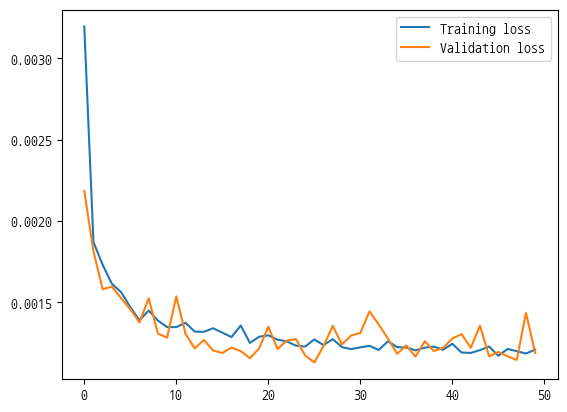

In [28]:
#위 model의 loss 등 출력
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

### 7) Model로 예측값 얻기 ####
#### - 주1) Model을 만들때의 입력데이터 구조와 동일한 구조의 테스트데이터를 입력해야 model이 동작
#### - 주2) data structure
#####     ---- input(입력, 3 Dimention 구조여야 함)의 input_shape : (count, row/steps, column/features)
#####     ---- output(출력) : 예측값

#### >>> test데이터(df_only_pm_values_for_test) 준비: test데이터는 transform만 수행해야됨 ( fit_transform 아님)
#### >>>>> Dimentionality 반드시 일치시켜야 함(tranform할때와, inverse_transform할때

In [29]:
df_only_pm_values_for_test.shape

(2408, 4)

In [30]:
#### (1)test데이터 transform 수행
test_data_scaled = scaler.transform(df_only_pm_values_for_test)
test_data_scaled

array([[0.05194805, 0.04782609, 0.02293578, 0.07801418],
       [0.08441558, 0.06956522, 0.02752294, 0.07801418],
       [0.09090909, 0.07391304, 0.0412844 , 0.09929078],
       ...,
       [0.05844156, 0.04782609, 0.01834862, 0.10638298],
       [0.05844156, 0.04782609, 0.01834862, 0.10638298],
       [0.05844156, 0.04782609, 0.01834862, 0.10638298]])

In [31]:
#### (2)tranform된 데이터(test_data_scaled) split 수행
# choose a number of time steps and input dimention(columns)
n_steps_in = 5

# split into samples
x_test_data_for_lstm_scaled, y_test_data_for_lstm_scaled = split_sequence(test_data_scaled, n_steps_in)
# summarize the data
print(x_test_data_for_lstm_scaled.shape)
print(y_test_data_for_lstm_scaled.shape)

(2403, 5, 3)
(2403,)


In [32]:
x_test_data_for_lstm_scaled

array([[[0.04782609, 0.02293578, 0.07801418],
        [0.06956522, 0.02752294, 0.07801418],
        [0.07391304, 0.0412844 , 0.09929078],
        [0.06521739, 0.06880734, 0.09929078],
        [0.07391304, 0.05045872, 0.10638298]],

       [[0.06956522, 0.02752294, 0.07801418],
        [0.07391304, 0.0412844 , 0.09929078],
        [0.06521739, 0.06880734, 0.09929078],
        [0.07391304, 0.05045872, 0.10638298],
        [0.07391304, 0.08256881, 0.12056738]],

       [[0.07391304, 0.0412844 , 0.09929078],
        [0.06521739, 0.06880734, 0.09929078],
        [0.07391304, 0.05045872, 0.10638298],
        [0.07391304, 0.08256881, 0.12056738],
        [0.09130435, 0.08715596, 0.14893617]],

       ...,

       [[0.04782609, 0.01834862, 0.10638298],
        [0.04782609, 0.01834862, 0.10638298],
        [0.04782609, 0.01834862, 0.10638298],
        [0.04782609, 0.01834862, 0.10638298],
        [0.04782609, 0.01834862, 0.10638298]],

       [[0.04782609, 0.01834862, 0.10638298],
        [0.04

In [33]:
y_test_data_for_lstm_scaled

array([0.11688312, 0.14285714, 0.14935065, ..., 0.05844156, 0.05844156,
       0.05844156])

In [34]:
y_test_data_for_lstm_scaled[0]

0.1168831168831169

In [35]:
x_test_data_for_lstm_scaled[0]

array([[0.04782609, 0.02293578, 0.07801418],
       [0.06956522, 0.02752294, 0.07801418],
       [0.07391304, 0.0412844 , 0.09929078],
       [0.06521739, 0.06880734, 0.09929078],
       [0.07391304, 0.05045872, 0.10638298]])

#### 7)[Case 1] (scale된 데이터로 비교) test데이터(x_test_data_for_lstm)로 예측치(y_pred1) 구하고 -> 정확도 비교하기

##### (1) test데이터(x_test_data_for_lstm)를 transform
##### (2) (1)을 입력으로하여, 예측값(y_pred1) 구하기
##### (3) (2)의 예측값(y_pred1)을 inverse_transform => (4) 실제값(y_test)을 비교하여 model 정확도 평가

In [36]:
x_test_data_for_lstm_scaled.shape

(2403, 5, 3)

In [37]:
x_test_data_for_lstm_scaled[0].shape

(5, 3)

In [38]:
x_test_data_for_lstm_scaled[0].reshape(5,3)

array([[0.04782609, 0.02293578, 0.07801418],
       [0.06956522, 0.02752294, 0.07801418],
       [0.07391304, 0.0412844 , 0.09929078],
       [0.06521739, 0.06880734, 0.09929078],
       [0.07391304, 0.05045872, 0.10638298]])

In [39]:
y_test_data_for_lstm_scaled[0]

0.1168831168831169

#### 예측 -> 정확도 비교하기(scale된 데이터로 비교)

In [40]:
### 체크용(lstm model 입력값)
x_ttest = np.array([
    [
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13]],
    [
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13],
    [0.1, 0.11, 0.13]]
])
x_ttest.shape

(2, 5, 3)

In [41]:
### 체크용(예측값)
y_pred1 = model.predict(x_ttest)

# y_pred1 = model.predict(x_test_data_for_lstm_scaled[0].reshape(-1,2))
# y_pred2 = scaler.inverse_transform(y_pred1)
print(y_pred1)

1/1 [==============================] - 0s 258ms/step
[[0.15156518]
 [0.15156518]]


### >>>> (1개 데이터에 대하여) 예측 정확도 확인(case 1)

In [42]:
x_test_sample=x_test_data_for_lstm_scaled[0]
print(x_test_sample.shape)
x_test_sample_reshape = x_test_sample.reshape(-1, 5, 3)
print(x_test_sample_reshape.shape)

y_pred1 = model.predict(x_test_sample_reshape)
print('y_pred : ', y_pred1[0][0])
print('y_test : ', y_test_data_for_lstm_scaled[0])

(5, 3)
(1, 5, 3)
1/1 [==============================] - 0s 20ms/step
y_pred :  0.115106314
y_test :  0.1168831168831169


### >>>> (1개 데이터에 대하여) 예측 정확도 확인(case 2)

In [43]:
y_pred1 = model.predict(x_test_data_for_lstm_scaled)
print('(input)one x data sample : ', x_test_data_for_lstm_scaled[0])
print('(test)one y data : ', y_test_data_for_lstm_scaled[0])
print('(predict)one y data : ', y_pred1[0][0])

76/76 [==============================] - 0s 5ms/step
(input)one x data sample :  [[0.04782609 0.02293578 0.07801418]
 [0.06956522 0.02752294 0.07801418]
 [0.07391304 0.0412844  0.09929078]
 [0.06521739 0.06880734 0.09929078]
 [0.07391304 0.05045872 0.10638298]]
(test)one y data :  0.1168831168831169
(predict)one y data :  0.115106314


### >>>> (전체 테스트 데이터에 대하여) 예측 정확도 확인(case 3)

In [46]:
### (전체 데이터에 대하여) 예측 정확도 확인(case 3)
y_pred1 = model.predict(x_test_data_for_lstm_scaled)
# print('(input)one x data sample : ', x_test_data_for_lstm_scaled[0])
# print('(test)one y data : ', y_test_data_for_lstm_scaled[0])
# print('(predict)one y data : ', y_pred1[0])

#(2)# model 정확도 평가
# model의 정확도(accuracy) 평가(1)
# mse : mean((실제값-예측값)^2)
from sklearn import metrics
print('Mean Squared Error : ', metrics.mean_squared_error(y_test_data_for_lstm_scaled, y_pred1))

# model의 정확도(accuracy) 평가(2)
# mae : mean(abs(실제값-예측값))
print('Mean absolute error : ', metrics.mean_absolute_error(y_test_data_for_lstm_scaled, y_pred1))

# R2
# from sklearn.metrics import r2_score
r2_y_predict = r2_score(y_test_data_for_lstm_scaled, y_pred1)
print('R2 : ', r2_y_predict)

76/76 [==============================] - 0s 5ms/step
Mean Squared Error :  0.0006200072118591108
Mean absolute error :  0.019088419811585825
R2 :  0.8581771955961001


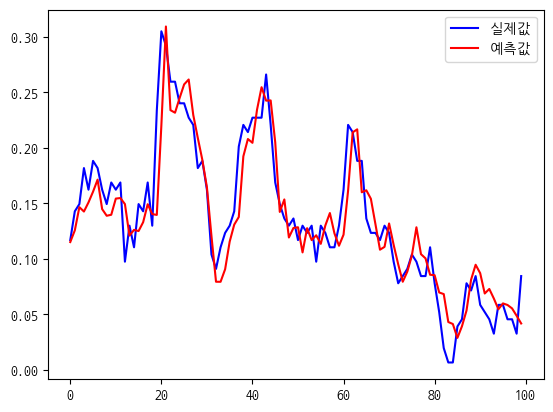

In [49]:
x_axis = range(len(y_test_data_for_lstm_scaled))
size_data = 100
plt.plot(x_axis[:size_data], y_test_data_for_lstm_scaled[:size_data], 'b', x_axis[:size_data], y_pred1[:size_data], 'r')
plt.legend(['실제값','예측값'])
plt.show()

#### 7) [Case 2] (원복하여 비교하기) scaled데이터(y_test_data_for_lstm_scaled, y_pred1)를 원복(inverse) 시킨 후 -> 정확도 비교하기

In [50]:
y_test_data_for_lstm_scaled.shape

(2403,)

In [51]:
y_pred1.shape

(2403, 1)

In [52]:
d_ttt = np.array([1,2,3,4,5])
d_ttt[0:-1]

array([1, 2, 3, 4])

In [54]:
# y_test_data_for_lstm_scaled, y_pred1를 원복
y_test_data_to_inverse = y_test_data_for_lstm_scaled.reshape(-1,1)
y_pred1_to_inverse = y_pred1.reshape(-1,1)
# y_pred1_to_inverse.shape, y_test_data_to_inverse.shape

cnt_pred_data = len(y_pred1_to_inverse)
cnt_columns = df_only_pm_values_for_train.shape[1]
ram = cnt_pred_data % cnt_columns
# cnt_dif = cnt_columns-ram
y_test_data_to_inverse_pre = y_test_data_to_inverse[:cnt_pred_data-ram]
y_pred1_to_inverse_pre = y_pred1_to_inverse[:cnt_pred_data-ram]

# print(len(y_test_data_to_inverse_pre))
# print(len(y_pred1_to_inverse_pre))

### inverse_transform을 위해 dimentionality 맞추기(변경)
y_test_data_to_inverse_pre_st2 = y_test_data_to_inverse_pre.reshape(-1,cnt_columns)
y_pred1_to_inverse_pre_st2 = y_pred1_to_inverse_pre.reshape(-1,cnt_columns)

print(y_test_data_to_inverse_pre_st2.shape) # = y_test_data_to_inverse_pre.reshape(-1,cnt_steps,cnt_columns)
# y_pred1_to_inverse_pre_st2.shape# = y_pred1_to_inverse_pre.reshape(-1,cnt_steps,cnt_columns)
# print(y_test_data_to_inverse_pre_st2)
# print(y_pred1_to_inverse_pre_st2)
# print(df_only_pm_values_for_train.shape[1])
# y_test_data_to_inverse.shape, y_pred1.shape
y_testOrigin = scaler.inverse_transform(y_test_data_to_inverse_pre_st2)
y_predOrigin = scaler.inverse_transform(y_pred1_to_inverse_pre_st2)

(600, 4)


In [55]:
### graph를 그리기 위해 1차원으로 변경하기

y_testOrigin_1dim = y_testOrigin.reshape(-1,1)
y_predOrigin_1dim = y_predOrigin.reshape(-1,1)

y_testOrigin_1dim

array([[19.        ],
       [33.85714286],
       [33.55844156],
       ...,
       [14.44155844],
       [13.74025974],
       [ 9.24025974]])

In [56]:
print('-'*20, '실제값(y_test)','-'*20)
print(y_testOrigin_1dim)
print('\n')
print('-'*20, '예측값(y_predict)','-'*20)
print(y_predOrigin_1dim)

-------------------- 실제값(y_test) --------------------
[[19.        ]
 [33.85714286]
 [33.55844156]
 ...
 [14.44155844]
 [13.74025974]
 [ 9.24025974]]


-------------------- 예측값(y_predict) --------------------
[[18.726374 ]
 [29.899832 ]
 [32.951996 ]
 ...
 [20.868923 ]
 [19.77186  ]
 [13.2769375]]


In [57]:
# model의 정확도(accuracy) 평가(1)
# mse : mean((실제값-예측값)^2)
from sklearn import metrics
print('Mean Squared Error : ', metrics.mean_squared_error(y_testOrigin_1dim, y_predOrigin_1dim))

# model의 정확도(accuracy) 평가(2)
# mae : mean(abs(실제값-예측값))
print('Mean absolute error : ', metrics.mean_absolute_error(y_testOrigin_1dim, y_predOrigin_1dim))

# model의 정확도(accuracy) 평가(3)
# R2
# from sklearn.metrics import r2_score
r2_y_predict = r2_score(y_testOrigin_1dim, y_predOrigin_1dim)
print('R2 : ', r2_y_predict)

Mean Squared Error :  22.191280873971543
Mean absolute error :  3.5330919011552853
R2 :  0.8697126121057375


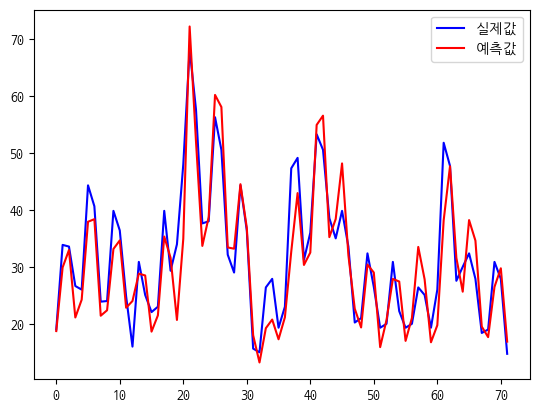

In [58]:
x_axis = range(len(y_predOrigin_1dim))
size_data = 24*3
plt.plot(x_axis[:size_data], y_testOrigin_1dim[:size_data], 'b', x_axis[:size_data], y_predOrigin_1dim[:size_data], 'r')
plt.legend(['실제값','예측값'])
plt.show()

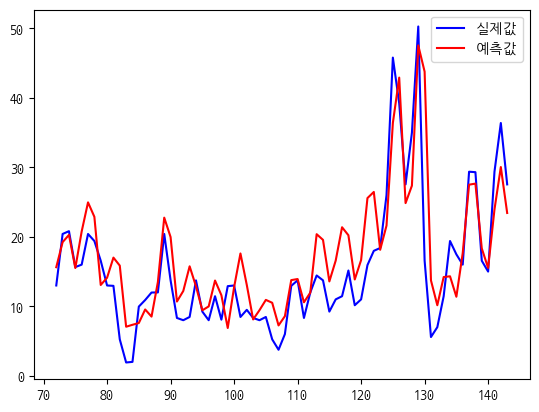

In [66]:
x_axis = range(len(y_predOrigin_1dim))
from_size_data = size_data
to_size_data = from_size_data + 24*3
plt.plot(x_axis[from_size_data:to_size_data], y_testOrigin_1dim[from_size_data:to_size_data], 'b', x_axis[from_size_data:to_size_data], y_predOrigin_1dim[from_size_data:to_size_data], 'r')
plt.legend(['실제값','예측값'])
plt.show()

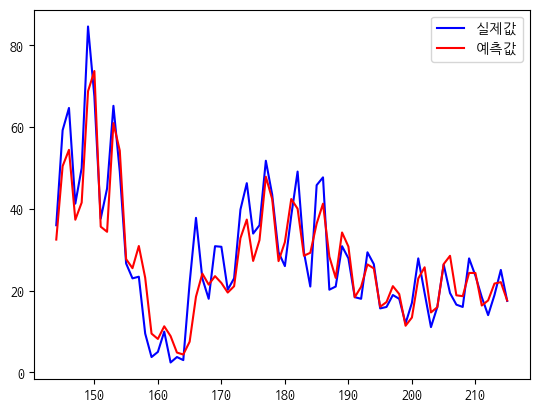

In [67]:
x_axis = range(len(y_predOrigin_1dim))
from_size_data = to_size_data
to_size_data = from_size_data+24*3
plt.plot(x_axis[from_size_data:to_size_data], y_testOrigin_1dim[from_size_data:to_size_data], 'b', x_axis[from_size_data:to_size_data], y_predOrigin_1dim[from_size_data:to_size_data], 'r')
plt.legend(['실제값','예측값'])
plt.show()

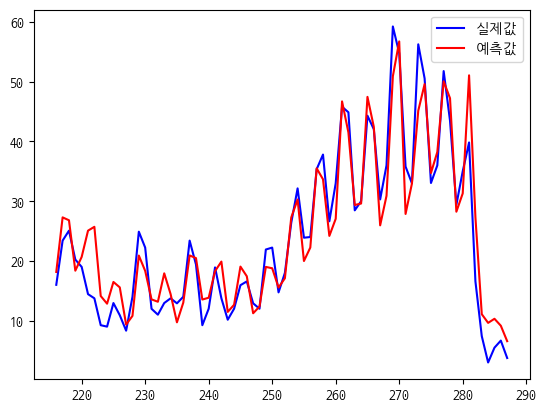

In [68]:
x_axis = range(len(y_predOrigin_1dim))
from_size_data = to_size_data
to_size_data = from_size_data+24*3
plt.plot(x_axis[from_size_data:to_size_data], y_testOrigin_1dim[from_size_data:to_size_data], 'b', x_axis[from_size_data:to_size_data], y_predOrigin_1dim[from_size_data:to_size_data], 'r')
plt.legend(['실제값','예측값'])
plt.show()

### 8) 모델 저장하기 ###

In [60]:
from keras.models import load_model
model.save('model_lstm_predict_pm_value_Tuning231206.h5')

#### 참고 #####